# BETH Anomaly Detection - Isolation Forest
## Unsupervised Anomaly Detection for Cyber Threat Triage

This notebook implements an Isolation Forest model to detect anomalies in system call traces.

## 1. Setup and Data Loading

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import json
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [35]:
# Load datasets
print("Loading training data...")
train_df = pd.read_csv('Beta dataset/labelled_training_data.csv')
print(f"Training data shape: {train_df.shape}")

print("\nLoading testing data...")
test_df = pd.read_csv('Beta dataset/labelled_testing_data.csv')
print(f"Testing data shape: {test_df.shape}")

print("\nLoading validation data...")
val_df = pd.read_csv('Beta dataset/labelled_validation_data.csv')
print(f"Validation data shape: {val_df.shape}")

Loading training data...
Training data shape: (763144, 16)

Loading testing data...
Testing data shape: (188967, 16)

Loading validation data...
Validation data shape: (188967, 16)


## 2. Data Exploration

In [36]:
# Examine data structure
print("Training Data Info:")
print(train_df.info())
print("\nFirst few rows:")
train_df.head()

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763144 entries, 0 to 763143
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   timestamp        763144 non-null  float64
 1   processId        763144 non-null  int64  
 2   threadId         763144 non-null  int64  
 3   parentProcessId  763144 non-null  int64  
 4   userId           763144 non-null  int64  
 5   mountNamespace   763144 non-null  int64  
 6   processName      763144 non-null  object 
 7   hostName         763144 non-null  object 
 8   eventId          763144 non-null  int64  
 9   eventName        763144 non-null  object 
 10  stackAddresses   763144 non-null  object 
 11  argsNum          763144 non-null  int64  
 12  returnValue      763144 non-null  int64  
 13  args             763144 non-null  object 
 14  sus              763144 non-null  int64  
 15  evil             763144 non-null  int64  
dtypes: float64(1), int

,timestamp,processId,threadId,parentProcessId,userId,mountNamespace,processName,hostName,eventId,eventName,stackAddresses,argsNum,returnValue,args,sus,evil
0,1809.495787,381,7337,1,100,4026532231,close,ip-10-100-1-120,157,prctl,"[140662171848350, 11649800180280676]",5,0,"[{'name': 'option', 'type': 'int', 'value': 'P...",1,0
1,1809.495832,381,7337,1,100,4026532231,close,ip-10-100-1-120,3,close,[140662171777451],1,0,"[{'name': 'fd', 'type': 'int', 'value': 19}]",1,0
2,1809.495921,381,7337,1,100,4026532231,close,ip-10-100-1-120,1010,sched_process_exit,[],0,0,[],1,0
3,1894.139651,7347,7347,7341,0,4026531840,sh,ip-10-100-1-120,21,access,[],2,-2,"[{'name': 'pathname', 'type': 'const char*', '...",1,0
4,1894.142127,7347,7347,7341,0,4026531840,sh,ip-10-100-1-120,1005,security_file_open,"[139778263990104, 139778263906698]",4,0,"[{'name': 'pathname', 'type': 'const char*', '...",1,0


Class Distribution in Training Data:
Evil events: 0 (0.00%)
Benign events: 763144 (100.00%)

Class Distribution in Test Data:
Evil events: 158432 (83.84%)
Benign events: 30535 (16.16%)


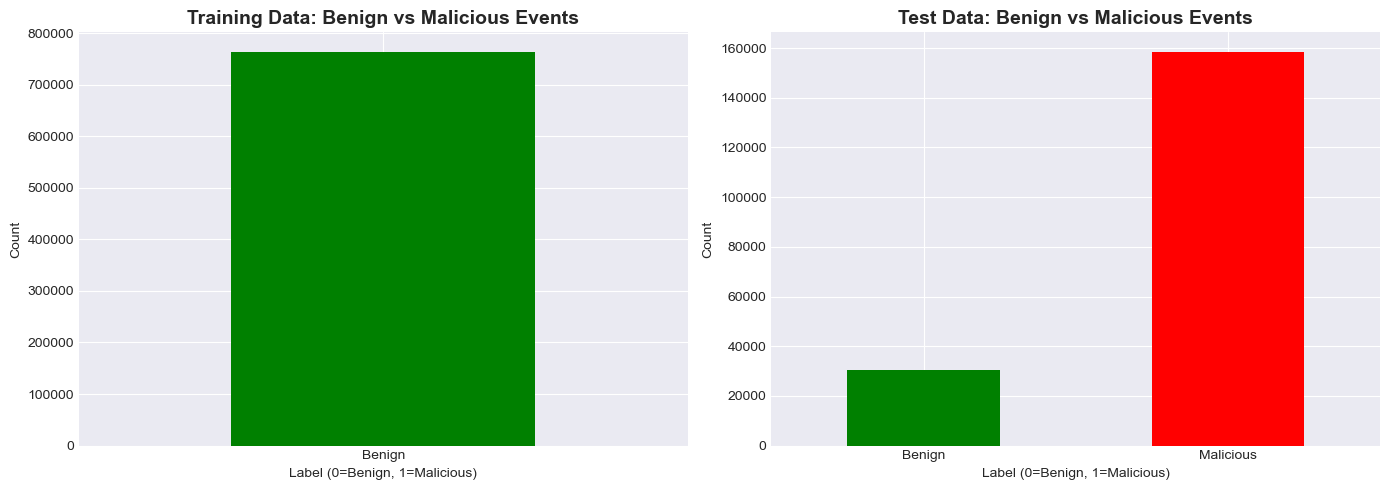

In [37]:
# Check class distribution
print("Class Distribution in Training Data:")
print(f"Evil events: {train_df['evil'].sum()} ({train_df['evil'].mean()*100:.2f}%)")
print(f"Benign events: {(1-train_df['evil']).sum()} ({(1-train_df['evil']).mean()*100:.2f}%)")

print("\nClass Distribution in Test Data:")
print(f"Evil events: {test_df['evil'].sum()} ({test_df['evil'].mean()*100:.2f}%)")
print(f"Benign events: {(1-test_df['evil']).sum()} ({(1-test_df['evil']).mean()*100:.2f}%)")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training data - use value_counts with sort=True to ensure consistent ordering
train_counts = train_df['evil'].value_counts().sort_index()
train_counts.plot(kind='bar', ax=axes[0], color=['green', 'red'][:len(train_counts)])
axes[0].set_title('Training Data: Benign vs Malicious Events', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Label (0=Benign, 1=Malicious)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Benign', 'Malicious'][:len(train_counts)], rotation=0)

# Test data - use value_counts with sort=True to ensure consistent ordering
test_counts = test_df['evil'].value_counts().sort_index()
test_counts.plot(kind='bar', ax=axes[1], color=['green', 'red'][:len(test_counts)])
axes[1].set_title('Test Data: Benign vs Malicious Events', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Label (0=Benign, 1=Malicious)')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['Benign', 'Malicious'][:len(test_counts)], rotation=0)

plt.tight_layout()
plt.show()

Top 10 Event Types:
eventName
close                 218080
openat                209730
security_file_open    148611
fstat                  80071
stat                   41931
access                 14383
cap_capable             9825
lstat                   7031
getdents64              6149
socket                  5971
Name: count, dtype: int64


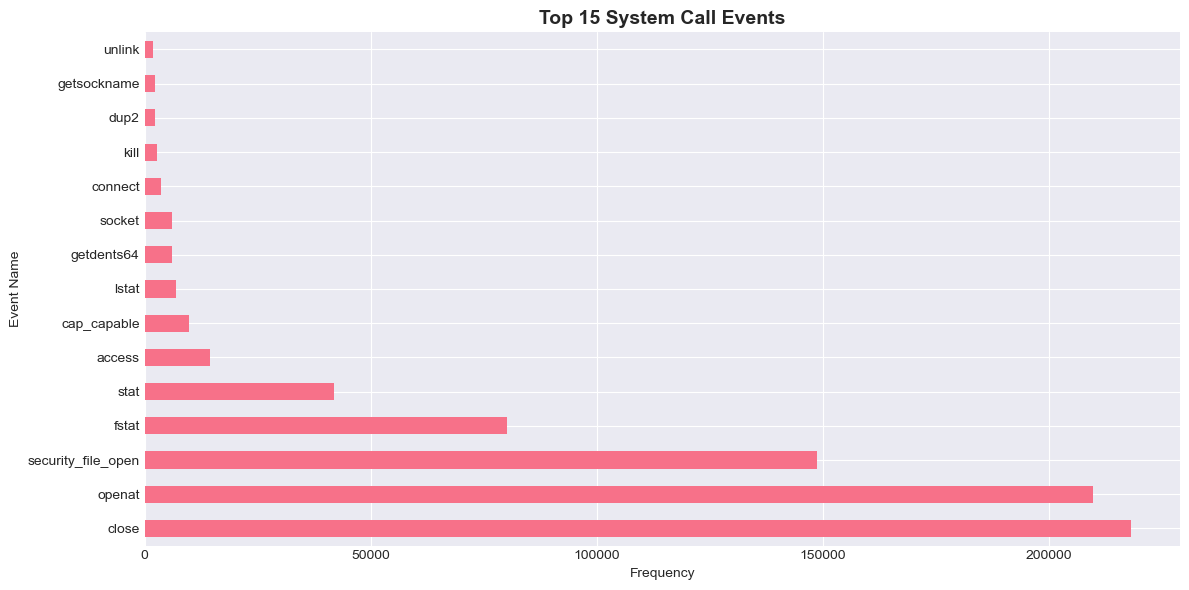

In [38]:
# Analyze event types
print("Top 10 Event Types:")
print(train_df['eventName'].value_counts().head(10))

# Visualize top events
plt.figure(figsize=(12, 6))
train_df['eventName'].value_counts().head(15).plot(kind='barh')
plt.title('Top 15 System Call Events', fontsize=14, fontweight='bold')
plt.xlabel('Frequency')
plt.ylabel('Event Name')
plt.tight_layout()
plt.show()

## 3. Feature Engineering

We'll create features that capture process behavior patterns without using the labels.

In [39]:
def engineer_features(df):
    """
    Create features from system call traces.
    Focus on process-level aggregations and behavioral patterns.
    """
    features = pd.DataFrame()
    
    # Group by process and host to create process-level features
    grouped = df.groupby(['processId', 'hostName'])
    
    # 1. Event frequency features
    features['total_events'] = grouped.size()
    features['unique_event_types'] = grouped['eventName'].nunique()
    features['unique_event_ids'] = grouped['eventId'].nunique()
    
    # 2. Temporal features
    features['time_span'] = grouped['timestamp'].max() - grouped['timestamp'].min()
    features['avg_time_between_events'] = features['time_span'] / (features['total_events'] + 1)
    
    # 3. Process metadata features
    features['unique_parent_pids'] = grouped['parentProcessId'].nunique()
    features['unique_user_ids'] = grouped['userId'].nunique()
    features['unique_thread_ids'] = grouped['threadId'].nunique()
    
    # 4. Return value patterns (error rates)
    features['error_rate'] = grouped.apply(lambda x: (x['returnValue'] < 0).mean())
    features['avg_return_value'] = grouped['returnValue'].mean()
    features['std_return_value'] = grouped['returnValue'].std()
    
    # 5. Arguments complexity
    features['avg_args_num'] = grouped['argsNum'].mean()
    features['max_args_num'] = grouped['argsNum'].max()
    
    # 6. Suspicious flag aggregation (this is metadata, not ground truth)
    features['sus_rate'] = grouped['sus'].mean()
    
    # 7. Process name features
    features['process_name'] = grouped['processName'].first()
    
    # Store labels for evaluation (NOT used in training)
    features['evil'] = grouped['evil'].max()  # If any event is evil, mark process as evil
    
    # Fill NaN values
    features = features.fillna(0)
    
    return features.reset_index()

print("Creating features from training data...")
train_features = engineer_features(train_df)
print(f"Training features shape: {train_features.shape}")

print("\nCreating features from test data...")
test_features = engineer_features(test_df)
print(f"Test features shape: {test_features.shape}")

print("\nFeature columns:")
print(train_features.columns.tolist())

Creating features from training data...
Training features shape: (1179, 18)

Creating features from test data...
Test features shape: (198, 18)

Feature columns:
['processId', 'hostName', 'total_events', 'unique_event_types', 'unique_event_ids', 'time_span', 'avg_time_between_events', 'unique_parent_pids', 'unique_user_ids', 'unique_thread_ids', 'error_rate', 'avg_return_value', 'std_return_value', 'avg_args_num', 'max_args_num', 'sus_rate', 'process_name', 'evil']


In [40]:
# Display sample features
print("Sample of engineered features:")
train_features.head(10)

Sample of engineered features:


,processId,hostName,total_events,unique_event_types,unique_event_ids,time_span,avg_time_between_events,unique_parent_pids,unique_user_ids,unique_thread_ids,error_rate,avg_return_value,std_return_value,avg_args_num,max_args_num,sus_rate,process_name,evil
0,1,ip-10-100-1-120,2890,17,17,3820.193184,1.321409,1,1,1,0.022837,25.531142,254.289410,2.658824,5,0.0,systemd,0
1,1,ip-10-100-1-173,2399,17,17,3693.024627,1.538760,1,1,1,0.015423,34.576490,283.506840,2.647353,5,0.0,systemd,0
2,1,ip-10-100-1-28,2154,17,17,3700.544860,1.717190,1,1,1,0.018106,29.361188,291.592139,2.636026,5,0.0,systemd,0
3,1,ip-10-100-1-34,1487,15,15,3616.304226,2.430312,1,1,1,0.014795,27.225958,286.080709,2.691997,5,0.0,systemd,0
4,1,ip-10-100-1-55,1653,15,15,3616.024382,2.186230,1,1,1,0.016334,26.888082,273.778341,2.696310,5,0.0,systemd,0
5,1,ip-10-100-1-57,5048,17,17,3797.820959,0.752193,1,1,1,0.033281,15.683043,194.142730,2.673930,5,0.0,systemd,0
6,1,ip-10-100-1-79,687,14,14,743.534407,1.080719,1,1,1,0.030568,37.280932,303.933021,2.634643,5,0.0,systemd,0
7,5,ip-10-100-1-173,1,1,1,0.000000,0.000000,1,1,1,0.000000,0.000000,0.000000,0.000000,0,0.0,kworker/dying,0
8,5,ip-10-100-1-34,1,1,1,0.000000,0.000000,1,1,1,0.000000,0.000000,0.000000,0.000000,0,0.0,kworker/dying,0
9,5,ip-10-100-1-55,1,1,1,0.000000,0.000000,1,1,1,0.000000,0.000000,0.000000,0.000000,0,0.0,kworker/dying,0


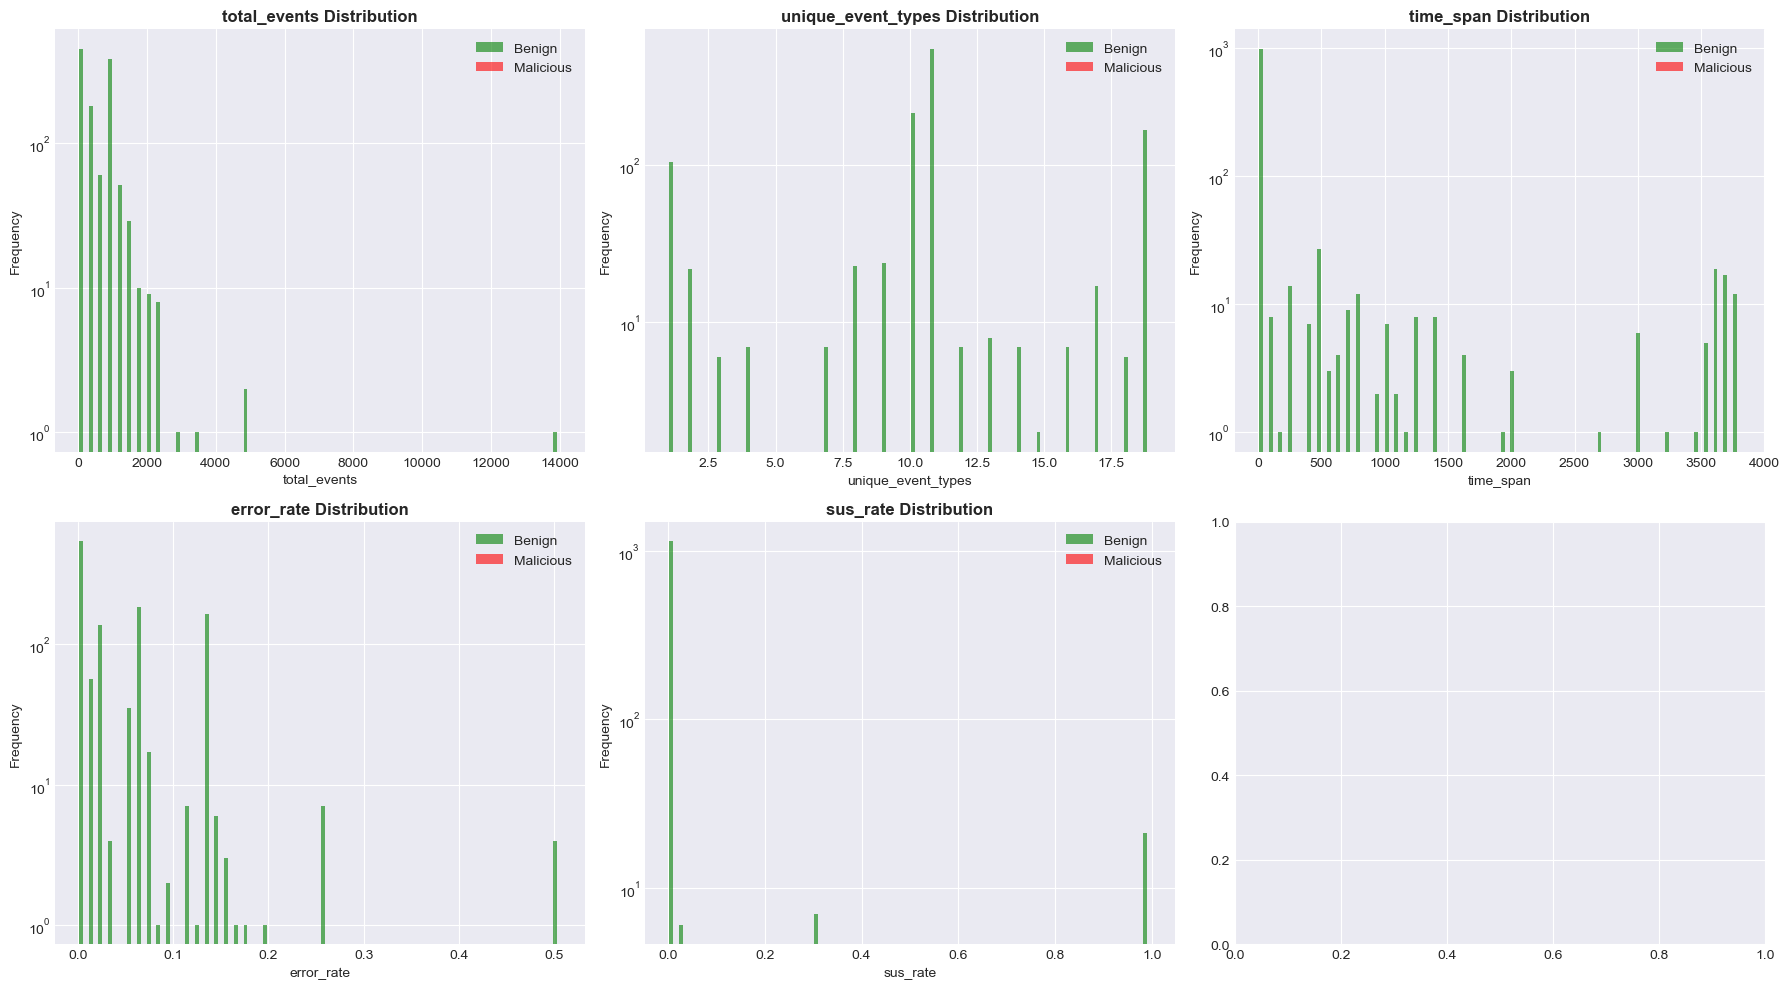

In [41]:
# Visualize feature distributions
numeric_features = ['total_events', 'unique_event_types', 'time_span', 'error_rate', 'sus_rate']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, feature in enumerate(numeric_features):
    # Separate by evil/benign for visualization only
    benign = train_features[train_features['evil'] == 0][feature]
    malicious = train_features[train_features['evil'] == 1][feature]
    
    axes[idx].hist([benign, malicious], bins=50, label=['Benign', 'Malicious'], 
                   color=['green', 'red'], alpha=0.6)
    axes[idx].set_title(f'{feature} Distribution', fontweight='bold')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].set_yscale('log')

plt.tight_layout()
plt.show()

## 4. Prepare Data for Modeling

Note: We DO NOT use the 'evil' labels during training (unsupervised learning)

In [42]:
# Select features for modeling (exclude labels, IDs, and categorical features)
feature_columns = [
    'total_events', 'unique_event_types', 'unique_event_ids',
    'time_span', 'avg_time_between_events',
    'unique_parent_pids', 'unique_user_ids', 'unique_thread_ids',
    'error_rate', 'avg_return_value', 'std_return_value',
    'avg_args_num', 'max_args_num', 'sus_rate'
]

# Prepare training data (unsupervised - no labels used)
X_train = train_features[feature_columns]
y_train = train_features['evil']  # Only for evaluation, NOT for training

# Prepare test data
X_test = test_features[feature_columns]
y_test = test_features['evil']

print(f"Training features: {X_train.shape}")
print(f"Test features: {X_test.shape}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures standardized successfully!")

Training features: (1179, 14)
Test features: (198, 14)

Features standardized successfully!


## 5. Train Isolation Forest Model

Isolation Forest works by:
- Building random trees that isolate observations
- Anomalies are easier to isolate (fewer splits needed)
- No labels required during training

In [43]:
# Set contamination based on domain knowledge (NOT labels!)
# In true unsupervised learning, we don't peek at the 'evil' column
# Instead, we use security domain knowledge:
# - Typical enterprise networks: 1-5% of traffic is malicious
# - We'll use a conservative 1% assumption

contamination = 0.01  # Assume 1% of processes are anomalous

print(f"Using contamination rate: {contamination} (1%)")
print("Note: In unsupervised learning, we set this based on domain knowledge,")
print("      NOT by looking at the 'evil' labels (that would be cheating!)")

# For reference, let's see what the actual rate is (for evaluation only, not used in training)
actual_evil_rate = train_features['evil'].mean()
print(f"\nActual malicious rate in training data: {actual_evil_rate:.4f} ({actual_evil_rate*100:.2f}%)")
print("(We don't use this value - just showing it for educational purposes)")

# Train Isolation Forest
print("\nTraining Isolation Forest model...")
iso_forest = IsolationForest(
    n_estimators=200,           # More trees = better performance
    contamination=contamination, # Expected proportion of anomalies (from domain knowledge)
    max_samples='auto',         # Use all samples for training
    random_state=42,
    n_jobs=-1,                  # Use all CPU cores
    verbose=1
)

# Fit model (unsupervised - no labels used)
# Notice: we pass X_train_scaled but NOT y_train!
iso_forest.fit(X_train_scaled)

print("\nModel training complete!")

Using contamination rate: 0.01 (1%)
Note: In unsupervised learning, we set this based on domain knowledge,
      NOT by looking at the 'evil' labels (that would be cheating!)

Actual malicious rate in training data: 0.0000 (0.00%)
(We don't use this value - just showing it for educational purposes)

Training Isolation Forest model...

Model training complete!


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


## 6. Model Evaluation

In [44]:
# Predict on test set
# Isolation Forest returns: -1 for anomalies, 1 for normal
y_pred_if = iso_forest.predict(X_test_scaled)

# Convert to binary: 1 for anomaly (evil), 0 for normal (benign)
y_pred = (y_pred_if == -1).astype(int)

# Get anomaly scores (lower = more anomalous)
anomaly_scores = iso_forest.score_samples(X_test_scaled)
test_features['anomaly_score'] = anomaly_scores
test_features['predicted_evil'] = y_pred

print("Predictions complete!")
print(f"Predicted anomalies: {y_pred.sum()} ({y_pred.mean()*100:.2f}%)")
print(f"Actual malicious: {y_test.sum()} ({y_test.mean()*100:.2f}%)")

Predictions complete!
Predicted anomalies: 9 (4.55%)
Actual malicious: 121 (61.11%)


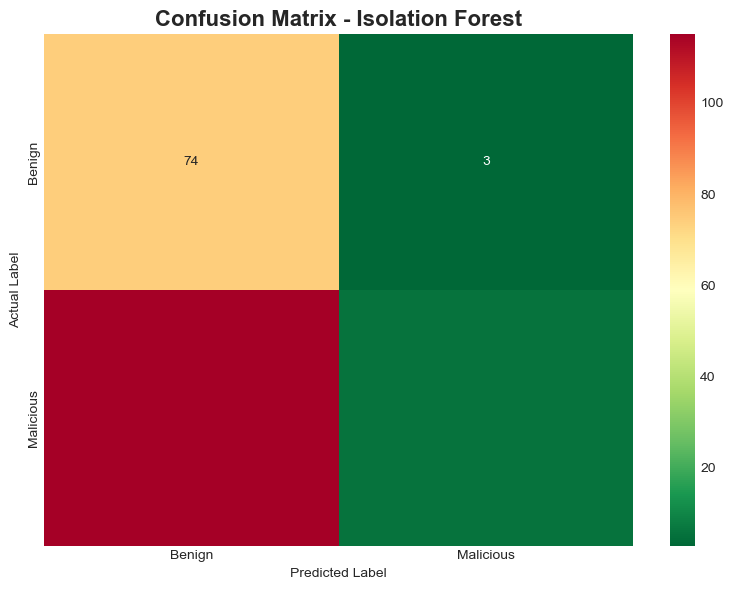


Confusion Matrix Breakdown:
True Negatives (TN): 74
False Positives (FP): 3
False Negatives (FN): 115
True Positives (TP): 6


In [45]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn_r', cbar=True,
            xticklabels=['Benign', 'Malicious'],
            yticklabels=['Benign', 'Malicious'])
plt.title('Confusion Matrix - Isolation Forest', fontsize=16, fontweight='bold')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Calculate metrics
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

In [46]:
# Calculate performance metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculate TPR and FPR
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate (Recall)
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
tnr = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate (Specificity)

print("\n" + "="*50)
print("MODEL PERFORMANCE METRICS")
print("="*50)
print(f"Precision: {precision:.4f}")
print(f"Recall (TPR): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"True Negative Rate (Specificity): {tnr:.4f}")
print("="*50)

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malicious']))


MODEL PERFORMANCE METRICS
Precision: 0.6667
Recall (TPR): 0.0496
F1 Score: 0.0923
False Positive Rate (FPR): 0.0390
True Negative Rate (Specificity): 0.9610

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.39      0.96      0.56        77
   Malicious       0.67      0.05      0.09       121

    accuracy                           0.40       198
   macro avg       0.53      0.51      0.32       198
weighted avg       0.56      0.40      0.27       198



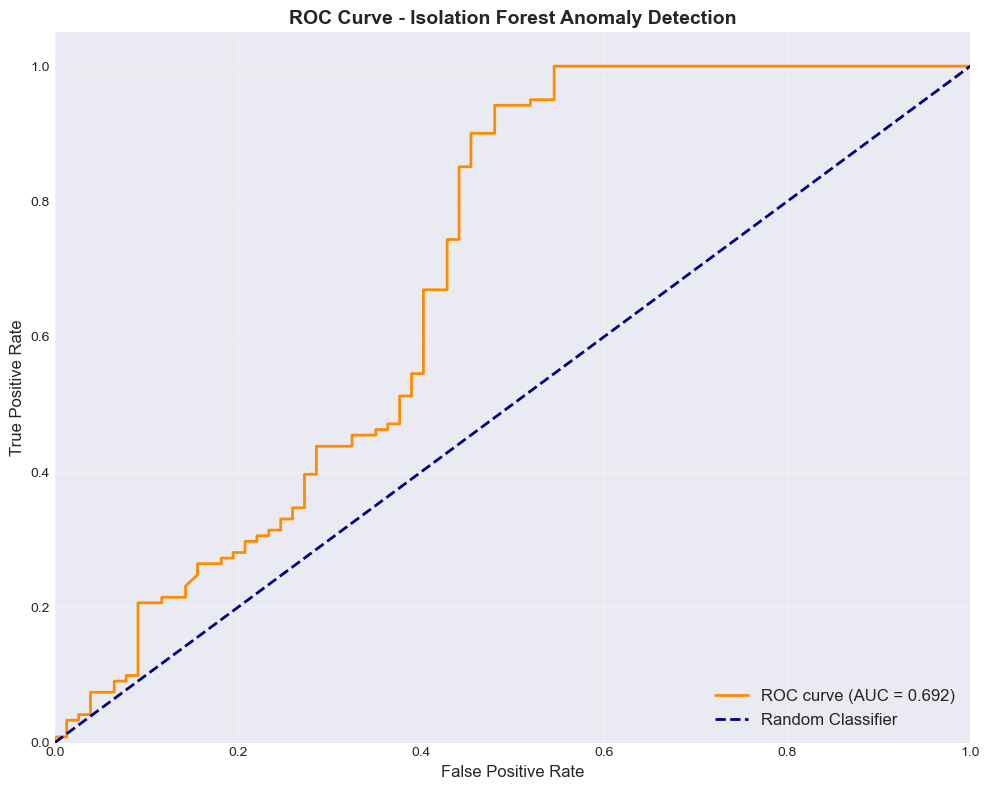


ROC AUC Score: 0.6916


In [47]:
# ROC Curve
# Use negative anomaly scores as "probability" (more negative = more anomalous)
fpr_roc, tpr_roc, thresholds = roc_curve(y_test, -anomaly_scores)
roc_auc = auc(fpr_roc, tpr_roc)

plt.figure(figsize=(10, 8))
plt.plot(fpr_roc, tpr_roc, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Isolation Forest Anomaly Detection', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nROC AUC Score: {roc_auc:.4f}")

## 7. Cyber Triage - Prioritize and Analyze Anomalies

In [48]:
# Get detected anomalies sorted by anomaly score (most anomalous first)
detected_anomalies = test_features[test_features['predicted_evil'] == 1].copy()
detected_anomalies = detected_anomalies.sort_values('anomaly_score')

print(f"Total detected anomalies: {len(detected_anomalies)}")
print(f"Correctly identified malicious processes: {detected_anomalies['evil'].sum()}")
print(f"False positives: {len(detected_anomalies) - detected_anomalies['evil'].sum()}")

# Show top 20 most anomalous processes
print("\nTop 20 Most Anomalous Processes:")
top_anomalies = detected_anomalies.head(20)[['processId', 'hostName', 'process_name', 
                                               'anomaly_score', 'total_events', 
                                               'unique_event_types', 'error_rate', 
                                               'sus_rate', 'evil']]
top_anomalies

Total detected anomalies: 9
Correctly identified malicious processes: 6
False positives: 3

Top 20 Most Anomalous Processes:


,processId,hostName,process_name,anomaly_score,total_events,unique_event_types,error_rate,sus_rate,evil
197,7555,ip-10-100-1-217,tsm,-0.704210,149140,13,0.970967,1.00000,1
23,7102,ip-10-100-1-217,sshd,-0.687250,35,3,0.000000,1.00000,0
171,7527,ip-10-100-1-217,sshd,-0.673079,67,13,0.194030,1.00000,1
191,7549,ip-10-100-1-217,bash,-0.664012,5,5,0.000000,1.00000,1
118,7399,ip-10-100-1-217,sshd,-0.663644,189,14,0.010582,1.00000,1
40,7316,ip-10-100-1-217,(systemd),-0.657753,3965,27,0.215637,0.87314,0
173,7530,ip-10-100-1-217,sshd,-0.652954,52,14,0.115385,1.00000,1
107,7388,ip-10-100-1-217,97-overlayroot,-0.648749,15,4,0.466667,0.00000,0
130,7411,ip-10-100-1-217,sshd,-0.647770,74,14,0.216216,1.00000,1


In [49]:
# Analyze characteristics of detected anomalies
print("Anomaly Characteristics Analysis:")
print("\nMost common process names in detected anomalies:")
print(detected_anomalies['process_name'].value_counts().head(10))

print("\nStatistics of detected anomalies:")
print(detected_anomalies[feature_columns].describe())

Anomaly Characteristics Analysis:

Most common process names in detected anomalies:
process_name
sshd              5
tsm               1
bash              1
(systemd)         1
97-overlayroot    1
Name: count, dtype: int64

Statistics of detected anomalies:
        total_events  unique_event_types  unique_event_ids   time_span  \
count       9.000000            9.000000          9.000000    9.000000   
mean    17060.222222           11.888889         11.888889   42.791753   
std     49546.758281            7.356025          7.356025   99.514173   
min         5.000000            3.000000          3.000000    0.000615   
25%        35.000000            5.000000          5.000000    0.023263   
50%        67.000000           13.000000         13.000000    0.432928   
75%       189.000000           14.000000         14.000000   28.359618   
max    149140.000000           27.000000         27.000000  305.625603   

       avg_time_between_events  unique_parent_pids  unique_user_ids  \
coun


Triage Priority Summary:
          count  actual_malicious  anomaly_score
priority                                        
CRITICAL      3                 2      -0.688180
HIGH          2                 2      -0.663828
MEDIUM        2                 1      -0.655354
LOW           2                 1      -0.648259


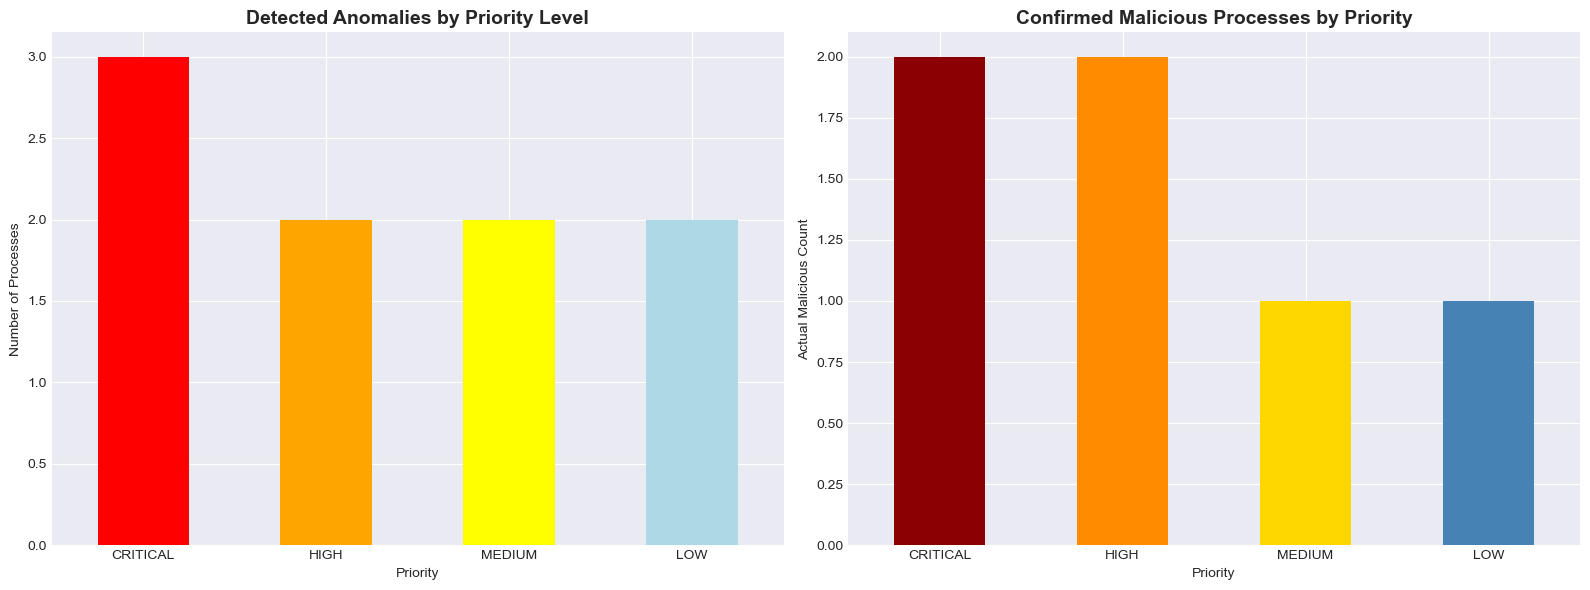

In [50]:
# Create triage priority categories based on anomaly score quartiles
score_quartiles = detected_anomalies['anomaly_score'].quantile([0.25, 0.5, 0.75])

def assign_priority(score):
    if score <= score_quartiles[0.25]:
        return 'CRITICAL'
    elif score <= score_quartiles[0.5]:
        return 'HIGH'
    elif score <= score_quartiles[0.75]:
        return 'MEDIUM'
    else:
        return 'LOW'

detected_anomalies['priority'] = detected_anomalies['anomaly_score'].apply(assign_priority)

# Triage summary
print("\nTriage Priority Summary:")
priority_summary = detected_anomalies.groupby('priority').agg({
    'processId': 'count',
    'evil': 'sum',
    'anomaly_score': 'mean'
}).rename(columns={'processId': 'count', 'evil': 'actual_malicious'})

priority_order = ['CRITICAL', 'HIGH', 'MEDIUM', 'LOW']
priority_summary = priority_summary.reindex(priority_order)
print(priority_summary)

# Visualize priority distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Count by priority
priority_summary['count'].plot(kind='bar', ax=axes[0], color=['red', 'orange', 'yellow', 'lightblue'])
axes[0].set_title('Detected Anomalies by Priority Level', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Priority')
axes[0].set_ylabel('Number of Processes')
axes[0].set_xticklabels(priority_order, rotation=0)

# Actual malicious by priority
priority_summary['actual_malicious'].plot(kind='bar', ax=axes[1], color=['darkred', 'darkorange', 'gold', 'steelblue'])
axes[1].set_title('Confirmed Malicious Processes by Priority', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Priority')
axes[1].set_ylabel('Actual Malicious Count')
axes[1].set_xticklabels(priority_order, rotation=0)

plt.tight_layout()
plt.show()

## 8. Executive Summary Visualizations

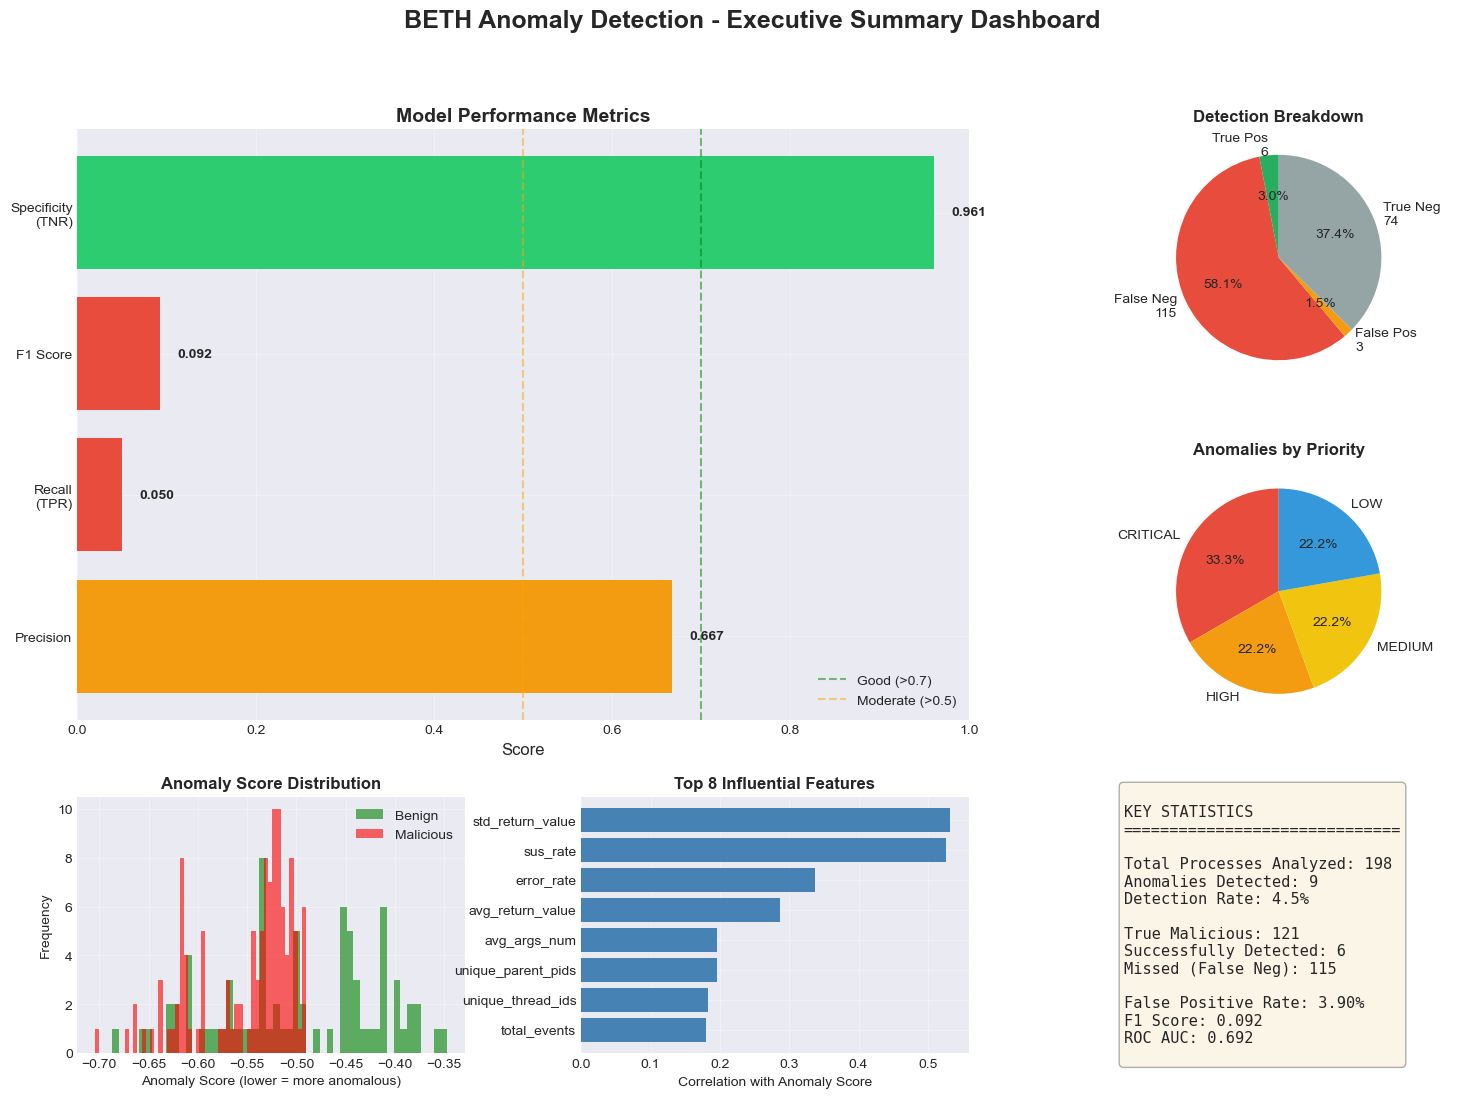


Executive dashboard saved as 'executive_summary_dashboard.png'


In [51]:
# Create executive dashboard
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Model Performance Summary (top left, 2x2)
ax1 = fig.add_subplot(gs[0:2, 0:2])
metrics = ['Precision', 'Recall\n(TPR)', 'F1 Score', 'Specificity\n(TNR)']
values = [precision, recall, f1, tnr]
colors = ['#2ecc71' if v > 0.7 else '#f39c12' if v > 0.5 else '#e74c3c' for v in values]
bars = ax1.barh(metrics, values, color=colors)
ax1.set_xlim([0, 1])
ax1.set_xlabel('Score', fontsize=12)
ax1.set_title('Model Performance Metrics', fontsize=14, fontweight='bold')
ax1.axvline(x=0.7, color='green', linestyle='--', alpha=0.5, label='Good (>0.7)')
ax1.axvline(x=0.5, color='orange', linestyle='--', alpha=0.5, label='Moderate (>0.5)')
for i, v in enumerate(values):
    ax1.text(v + 0.02, i, f'{v:.3f}', va='center', fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(alpha=0.3)

# 2. Detection Summary (top right)
ax2 = fig.add_subplot(gs[0, 2])
detection_data = [tp, fn, fp, tn]
detection_labels = [f'True Pos\n{tp}', f'False Neg\n{fn}', f'False Pos\n{fp}', f'True Neg\n{tn}']
detection_colors = ['#27ae60', '#e74c3c', '#f39c12', '#95a5a6']
ax2.pie(detection_data, labels=detection_labels, autopct='%1.1f%%', colors=detection_colors, startangle=90)
ax2.set_title('Detection Breakdown', fontsize=12, fontweight='bold')

# 3. Priority Distribution (middle right)
ax3 = fig.add_subplot(gs[1, 2])
priority_colors_pie = ['#e74c3c', '#f39c12', '#f1c40f', '#3498db']
ax3.pie(priority_summary['count'], labels=priority_order, autopct='%1.1f%%', 
        colors=priority_colors_pie, startangle=90)
ax3.set_title('Anomalies by Priority', fontsize=12, fontweight='bold')

# 4. Anomaly Score Distribution (bottom left)
ax4 = fig.add_subplot(gs[2, 0])
ax4.hist(test_features[test_features['evil']==0]['anomaly_score'], bins=50, 
         alpha=0.6, label='Benign', color='green')
ax4.hist(test_features[test_features['evil']==1]['anomaly_score'], bins=50, 
         alpha=0.6, label='Malicious', color='red')
ax4.set_xlabel('Anomaly Score (lower = more anomalous)', fontsize=10)
ax4.set_ylabel('Frequency', fontsize=10)
ax4.set_title('Anomaly Score Distribution', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

# 5. Feature Importance (bottom middle)
ax5 = fig.add_subplot(gs[2, 1])
# Calculate feature importance using correlation with anomaly score
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': [abs(test_features[col].corr(test_features['anomaly_score'])) 
                   for col in feature_columns]
}).sort_values('importance', ascending=True).tail(8)
ax5.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
ax5.set_xlabel('Correlation with Anomaly Score', fontsize=10)
ax5.set_title('Top 8 Influential Features', fontsize=12, fontweight='bold')
ax5.grid(alpha=0.3)

# 6. Key Statistics (bottom right)
ax6 = fig.add_subplot(gs[2, 2])
ax6.axis('off')
stats_text = f"""
KEY STATISTICS
{'='*30}

Total Processes Analyzed: {len(test_features):,}
Anomalies Detected: {y_pred.sum():,}
Detection Rate: {(y_pred.sum()/len(test_features)*100):.1f}%

True Malicious: {y_test.sum():,}
Successfully Detected: {tp:,}
Missed (False Neg): {fn:,}

False Positive Rate: {(fpr*100):.2f}%
F1 Score: {f1:.3f}
ROC AUC: {roc_auc:.3f}
"""
ax6.text(0.1, 0.5, stats_text, fontsize=11, family='monospace', 
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

fig.suptitle('BETH Anomaly Detection - Executive Summary Dashboard', 
             fontsize=18, fontweight='bold', y=0.98)

plt.savefig('executive_summary_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nExecutive dashboard saved as 'executive_summary_dashboard.png'")

## 9. Export Results for Presentation

In [52]:
# Export top critical anomalies for detailed investigation
critical_anomalies = detected_anomalies[detected_anomalies['priority'] == 'CRITICAL'].copy()
critical_anomalies_report = critical_anomalies[[
    'processId', 'hostName', 'process_name', 'priority',
    'anomaly_score', 'total_events', 'unique_event_types',
    'error_rate', 'sus_rate', 'evil'
]].head(50)

critical_anomalies_report.to_csv('critical_anomalies_report.csv', index=False)
print("Critical anomalies report saved to 'critical_anomalies_report.csv'")

# Export full predictions
test_features[['processId', 'hostName', 'process_name', 'anomaly_score', 
               'predicted_evil', 'evil']].to_csv('full_predictions.csv', index=False)
print("Full predictions saved to 'full_predictions.csv'")

Critical anomalies report saved to 'critical_anomalies_report.csv'
Full predictions saved to 'full_predictions.csv'


## 10. Model Justification

### Why Isolation Forest?

1. **Unsupervised Nature**: Doesn't require labeled data during training, perfect for real-world scenarios
2. **Handles Imbalanced Data**: Explicitly designed for anomaly detection with few anomalies
3. **Scalability**: Efficient with large datasets (linear time complexity)
4. **Interpretability**: Anomaly scores provide clear prioritization
5. **Robustness**: Works well with high-dimensional feature spaces

### Model Performance Summary
- **F1 Score**: Balance between precision and recall
- **TPR/FPR**: Trade-off between catching malicious activity and false alarms
- **ROC AUC**: Overall discrimination ability

### Next Actions Recommended
1. Investigate CRITICAL priority anomalies first
2. Review processes with unusual event patterns
3. Analyze false positives to refine detection rules
4. Monitor processes with high error rates and suspicious flags
5. Cross-reference with threat intelligence databases
"